<a href="https://colab.research.google.com/github/anaisaoviedo-upb/Ensambles/blob/main/Ensamble_para_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble de Clasificadores
1. Preparación de datos
2. División de datos
3. Clasificadores individuales (debiles)
4. Bagging
5. Random Forest
6. Boosting
7. Votación "hard"
8. Votación "soft"
9. Stacking
10. Guardamos el mejor modelo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Preparación de datos

In [ ]:
data = pd.read_excel("ataque_corazon.xlsx",sheet_name=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    5110 non-null   int64  
 1   hypertension           5110 non-null   object 
 2   heart_disease          5110 non-null   object 
 3   ever_married           5110 non-null   object 
 4   avg_glucose_level      5110 non-null   float64
 5   smoking_status         5110 non-null   object 
 6   stroke_ataque_corazon  5110 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 279.6+ KB


In [ ]:
data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,smoking_status,stroke_ataque_corazon
0,1,No,No,No,122.04,Unknown,No
1,79,No,No,Yes,79.03,Unknown,No
2,40,No,No,Yes,60.96,'never smoked',No
3,4,No,No,No,107.25,Unknown,No
4,8,No,No,No,106.51,Unknown,No


In [ ]:
#Corrección tipos de datos
data['hypertension']=data['hypertension'].astype('category')
data['heart_disease']=data['heart_disease'].astype('category')
data['ever_married']=data['ever_married'].astype('category')
data['smoking_status']=data['smoking_status'].astype('category')
data['stroke_ataque_corazon']=data['stroke_ataque_corazon'].astype('category')

<Axes: xlabel='stroke_ataque_corazon'>

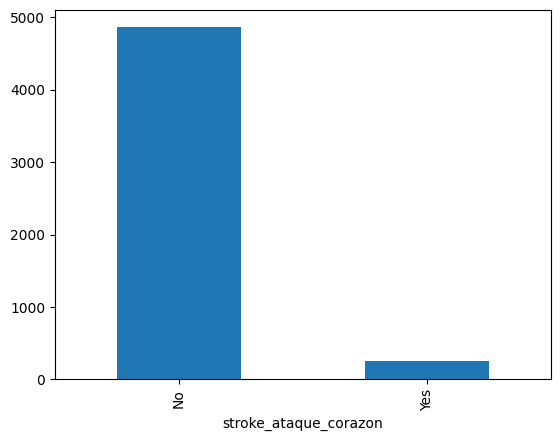

In [ ]:
data['stroke_ataque_corazon'].value_counts().plot(kind='bar')

In [ ]:
#Normalizacion las variables numéricas (las dummies no se normalizan)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
variables_numericas=['age','avg_glucose_level']

min_max_scaler.fit(data[variables_numericas]) #Ajuste de los parametros: max - min
data[variables_numericas]= min_max_scaler.transform(data[variables_numericas]) #70%
data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,smoking_status,stroke_ataque_corazon
0,0.000000,No,No,No,0.308928,Unknown,No
1,0.962963,No,No,Yes,0.110378,Unknown,No
2,0.481481,No,No,Yes,0.026960,'never smoked',No
3,0.037037,No,No,No,0.240652,Unknown,No
4,0.086420,No,No,No,0.237236,Unknown,No


In [ ]:
#Dummies para las variables predictoras
data = pd.get_dummies(data, columns=['smoking_status'], drop_first=False, dtype=int)
data = pd.get_dummies(data, columns=['hypertension','heart_disease','ever_married',], drop_first=True, dtype=int)

data.head()

,age,avg_glucose_level,stroke_ataque_corazon,smoking_status_'formerly smoked',smoking_status_'never smoked',smoking_status_Unknown,smoking_status_smokes,hypertension_Yes,heart_disease_Yes,ever_married_Yes
0,0.000000,0.308928,No,0,0,1,0,0,0,0
1,0.962963,0.110378,No,0,0,1,0,0,0,1
2,0.481481,0.026960,No,0,1,0,0,0,0,1
3,0.037037,0.240652,No,0,0,1,0,0,0,0
4,0.086420,0.237236,No,0,0,1,0,0,0,0


In [ ]:
#LabelEncoder para la variable objetivo
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data["stroke_ataque_corazon"]=labelencoder.fit_transform(data["stroke_ataque_corazon"])
data.head()

,age,avg_glucose_level,stroke_ataque_corazon,smoking_status_'formerly smoked',smoking_status_'never smoked',smoking_status_Unknown,smoking_status_smokes,hypertension_Yes,heart_disease_Yes,ever_married_Yes
0,0.000000,0.308928,0,0,0,1,0,0,0,0
1,0.962963,0.110378,0,0,0,1,0,0,0,1
2,0.481481,0.026960,0,0,1,0,0,0,0,1
3,0.037037,0.240652,0,0,0,1,0,0,0,0
4,0.086420,0.237236,0,0,0,1,0,0,0,0


# **2. División de Datos**

In [ ]:
#División 70-30
from sklearn.model_selection import train_test_split
X = data.drop("stroke_ataque_corazon", axis = 1)
Y = data['stroke_ataque_corazon']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

# **3. Clasificadores individuales - débiles (base learners)**

In [ ]:
#Arbol de clasificación
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=5)
model_dt.fit(X_train, Y_train)

#Evaluación
from sklearn import metrics
Y_pred = model_dt.predict(X_test)
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))



              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


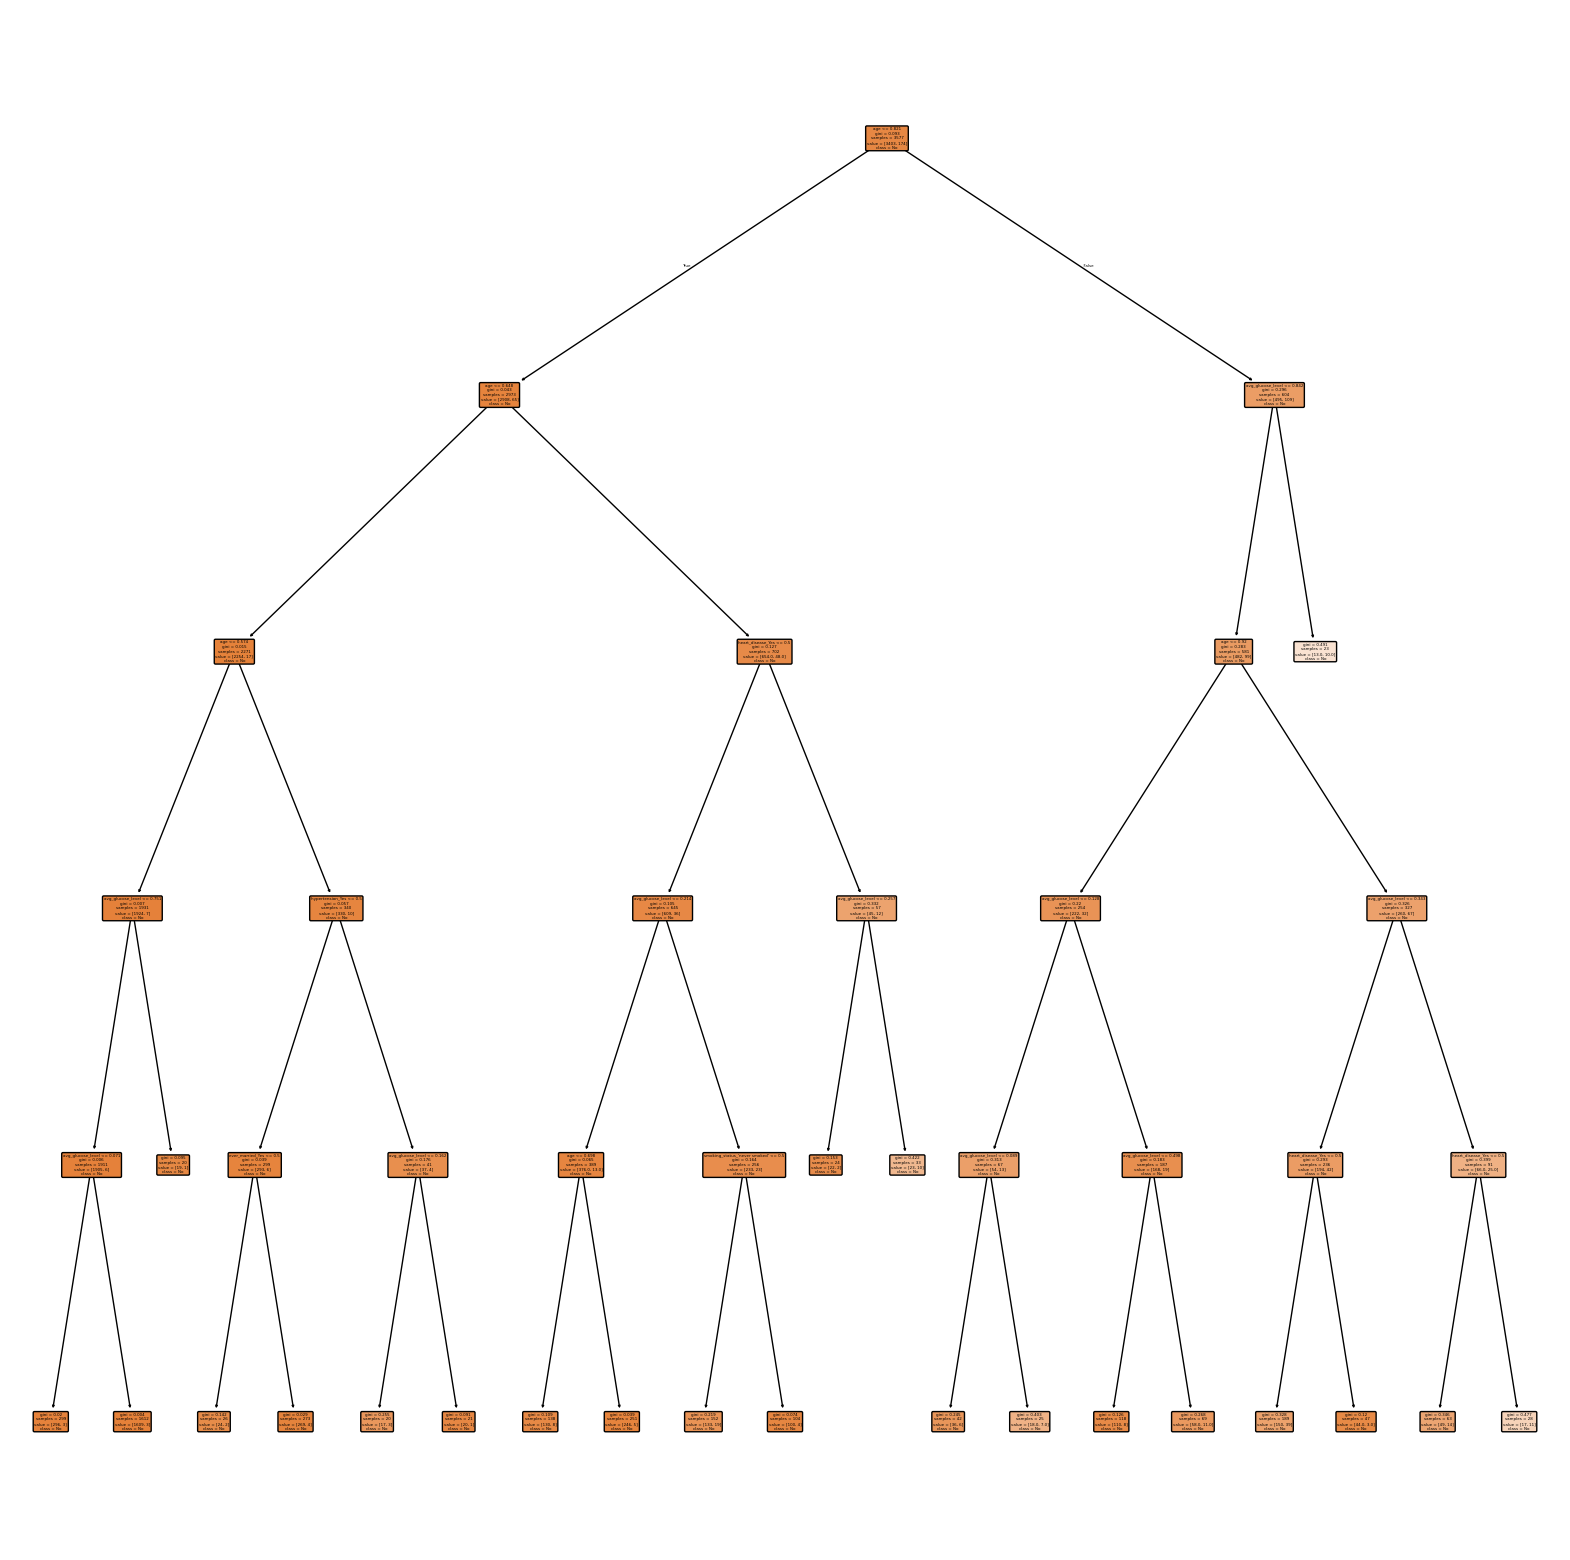

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(model_dt, feature_names=X_train.columns.values, class_names=labelencoder.classes_, rounded=True, filled=True)
plt.show()

In [ ]:
#Método Perezoso
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_knn.fit(X_train, Y_train)

#Evaluación
Y_pred = model_knn.predict(X_test)
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))




              precision    recall  f1-score   support

          No       0.96      0.96      0.96      1458
         Yes       0.14      0.13      0.14        75

    accuracy                           0.92      1533
   macro avg       0.55      0.55      0.55      1533
weighted avg       0.92      0.92      0.92      1533



In [ ]:
#Red neuronal
from sklearn.neural_network import MLPClassifier
model_rn = MLPClassifier(activation="relu",hidden_layer_sizes=(25), learning_rate='constant',
                     learning_rate_init=0.02, momentum= 0.3, max_iter=500, verbose=False)
model_rn.fit(X_train, Y_train)

#Evaluación
Y_pred = model_rn.predict(X_test)
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



# 4. Bagging

In [ ]:
#Bagging: Knn
from sklearn.ensemble import BaggingClassifier
modelo_base=KNeighborsClassifier(n_neighbors=1, metric='euclidean')

model_bag = BaggingClassifier(modelo_base, n_estimators=10, max_samples=0.6) #n_estimators=100
model_bag.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_bag.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))


              precision    recall  f1-score   support

          No       0.95      0.98      0.97      1458
         Yes       0.15      0.07      0.09        75

    accuracy                           0.94      1533
   macro avg       0.55      0.52      0.53      1533
weighted avg       0.91      0.94      0.92      1533



# 5. Random Forest (bagging)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(n_estimators=100,  max_samples=0.7, criterion='gini',
                              max_depth=None, min_samples_leaf=2)
model_rf.fit(X_train, Y_train) #70%


#Evaluación
Y_pred = model_rf.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))




              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [ ]:
# Se imprimen la importancia de las características
print('Importancia de las características')
for i, j in sorted(zip(X_train.columns, model_rf.feature_importances_)):
    print(i, j)

Importancia de las características
age 0.3796359370308475
avg_glucose_level 0.44134655010378865
ever_married_Yes 0.023059389685075024
heart_disease_Yes 0.03815614021042328
hypertension_Yes 0.03224002059285768
smoking_status_'formerly smoked' 0.021714952688073098
smoking_status_'never smoked' 0.023527026609301966
smoking_status_Unknown 0.01728489999549486
smoking_status_smokes 0.023035083084137903


# 6. Boosting

In [ ]:
#AdaBoost:Adaptive Boosting - Cada modelo siguiente se enfoca en los errores del anterior
from sklearn.ensemble import AdaBoostClassifier


modelo_base=DecisionTreeClassifier(criterion='gini', min_samples_leaf=2)
model_boos = AdaBoostClassifier(modelo_base, n_estimators=50)
model_boos.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_boos.predict(X_test)#30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))


              precision    recall  f1-score   support

          No       0.95      0.99      0.97      1458
         Yes       0.16      0.04      0.06        75

    accuracy                           0.94      1533
   macro avg       0.56      0.51      0.52      1533
weighted avg       0.91      0.94      0.93      1533



In [ ]:
# Gradient Boosting: utiliza gradiente descendente para ajustar los árboles en la dirección que reduce el error.


from sklearn.ensemble import GradientBoostingClassifier

#tasa de aprendizaje controla el tamaño de la actualización de cada modelo
model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, subsample=0.8, criterion='gini', min_samples_leaf=2, max_depth=10)
model_gbc.fit(X_train, Y_train) #70%


#Evaluación
Y_pred = model_gbc.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

          No       0.95      0.98      0.97      1458
         Yes       0.15      0.05      0.08        75

    accuracy                           0.94      1533
   macro avg       0.55      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



In [ ]:
# XGboost: Optimización extrema de Gradient Boosting.
# Procesamiento en paralelo, regularización, maneja valores faltantes
import xgboost as xgb


model_xgb = xgb.XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8  #enable_categorical=True,
)

model_xgb.fit(X_train, Y_train) #70%

#Evaluación
Y_pred = model_xgb.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

          No       0.95      0.99      0.97      1458
         Yes       0.25      0.05      0.09        75

    accuracy                           0.95      1533
   macro avg       0.60      0.52      0.53      1533
weighted avg       0.92      0.95      0.93      1533



In [ ]:

!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


In [ ]:
#CatBoostClassifier: especial para variables categóricas, sin crear dummies

from catboost import CatBoostClassifier

model_cat= CatBoostClassifier(iterations= 100,depth= 10, verbose= False,
                              cat_features=[]) #Variables categóricas
model_cat.fit(X_train, Y_train)


#Evaluación
Y_pred = model_cat.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.50      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.73      0.51      0.50      1533
weighted avg       0.93      0.95      0.93      1533



# 7. Votación "hard"

In [ ]:
#Votación hard: todos los modelos tiene el mismo peso
from sklearn.ensemble import VotingClassifier

clasificadores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

model_vot_hard = VotingClassifier(estimators=clasificadores, voting='hard')
model_vot_hard.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_hard.predict(X_test)#30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))


              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 8. Votación "soft"

In [ ]:
#Votación soft

from sklearn.ensemble import VotingClassifier

clasificadores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]
model_vot_soft = VotingClassifier(estimators=clasificadores, voting='soft', weights=[0.3, 0.4, 0.3])
model_vot_soft.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_soft.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))



              precision    recall  f1-score   support

          No       0.96      0.98      0.97      1458
         Yes       0.20      0.11      0.14        75

    accuracy                           0.93      1533
   macro avg       0.58      0.54      0.55      1533
weighted avg       0.92      0.93      0.93      1533



# 9. Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

clasificadores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

metodo_ensamblador= LogisticRegression() #SVM, NN, KNN


model_stack= StackingClassifier(estimators=clasificadores, final_estimator=metodo_ensamblador)
model_stack.fit(X_train,Y_train)#70%

#Evaluación
Y_pred = model_stack.predict(X_test) #30%
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

          No       0.95      1.00      0.97      1458
         Yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **10.Guardar el mejor modelo**

In [ ]:
import pickle
filename = 'modelo-ensamble-clas.pkl'
variables=X.columns._values
pickle.dump([model_vot_soft,variables, labelencoder, min_max_scaler], open(filename, 'wb'))

